# CAISO LMP Price Extraction

<b>Author:</b> Neal Ma

<b>Date:</b> October 6, 2024

<b>Description:</b> This notebook shows how to extract local marginal price (LMP) data from CAISO's OASIS API (https://www.caiso.com/Documents/OASIS-Frequently-Asked-Questions.pdf) and saves data to parquet file for easy storage and access.

In [1]:
import requests
import pandas as pd
import numpy as np
import os
import pyarrow as pa
import pyarrow.parquet as pq
import zipfile
import time
import matplotlib.pyplot as plt

In [16]:
START_DATE = "2021-06-15"
END_DATE = "today"

DATA_DOWNLOAD = True

BASEURL = "http://oasis.caiso.com/oasisapi/SingleZip?queryname=PRC_LMP"
VERSION = "12"
MARKET = "DAM"  # "DAM" for day-ahead market

NODES = ["MEADS_2_N101"]
TIMEZONE = "US/Pacific"  # see https://gist.github.com/heyalexej/8bf688fd67d7199be4a1682b3eec7568

CSV_STORAGE_PATH = "./data/LMP_CSV"
LMP_STORAGE_PATH = "./data/LMP"

In [17]:
# build the directory to store CSV files
if not os.path.exists(CSV_STORAGE_PATH):
    os.makedirs(CSV_STORAGE_PATH)

# build the directory to store the LMP table
if not os.path.exists(LMP_STORAGE_PATH):
    os.makedirs(LMP_STORAGE_PATH)

In [18]:
# only 31 days of data can be accessed at once so we iterate through every 15 days
timeseries = pd.date_range(
    start=pd.Timestamp(START_DATE), end=pd.Timestamp(END_DATE), freq="15D", tz=TIMEZONE
)


def format_datetime_str(ts: pd.Timestamp = None):
    # to deal with the '-' in the string format of the timezone
    temp_str = ts.strftime("%Y%m%dT%:z-0000").split("T")
    temp_str[1] = temp_str[1][1:]
    return "T".join(temp_str)

In [20]:
if DATA_DOWNLOAD:
    for idx in range(len(timeseries) - 1):

        url = BASEURL
        url += f"&startdatetime={format_datetime_str(timeseries[idx])}"
        url += f"&enddatetime={format_datetime_str(timeseries[idx+1])}"
        url += f"&version={VERSION}"
        url += f"&resultformat=6"
        url += f"&market_run_id={MARKET}"
        url += f"&node={','.join(NODES)}"

        response = requests.get(url)
        zip_path = os.path.join(CSV_STORAGE_PATH, f"data.zip")
        print(url)
        try:
            # Save the zip file
            with open(zip_path, "wb") as f:
                f.write(response.content)
            # Extract the csv file from the zip
            with zipfile.ZipFile(zip_path, "r") as zip_ref:
                zip_ref.extractall(CSV_STORAGE_PATH)

            # Delete the .zip file
            os.remove(zip_path)
        except:
            pass

        # Reduce request speed to avoid rate limits
        time.sleep(4)

http://oasis.caiso.com/oasisapi/SingleZip?queryname=PRC_LMP&startdatetime=20210615T07:00-0000&enddatetime=20210630T07:00-0000&version=12&resultformat=6&market_run_id=DAM&node=MEADS_2_N101
http://oasis.caiso.com/oasisapi/SingleZip?queryname=PRC_LMP&startdatetime=20210630T07:00-0000&enddatetime=20210715T07:00-0000&version=12&resultformat=6&market_run_id=DAM&node=MEADS_2_N101
http://oasis.caiso.com/oasisapi/SingleZip?queryname=PRC_LMP&startdatetime=20210715T07:00-0000&enddatetime=20210730T07:00-0000&version=12&resultformat=6&market_run_id=DAM&node=MEADS_2_N101
http://oasis.caiso.com/oasisapi/SingleZip?queryname=PRC_LMP&startdatetime=20210730T07:00-0000&enddatetime=20210814T07:00-0000&version=12&resultformat=6&market_run_id=DAM&node=MEADS_2_N101
http://oasis.caiso.com/oasisapi/SingleZip?queryname=PRC_LMP&startdatetime=20210814T07:00-0000&enddatetime=20210829T07:00-0000&version=12&resultformat=6&market_run_id=DAM&node=MEADS_2_N101
http://oasis.caiso.com/oasisapi/SingleZip?queryname=PRC_LMP&

In [23]:
# parquet save file path
parquet_path = os.path.join(
    LMP_STORAGE_PATH, f'{"_".join(NODES)}_{MARKET}_DATA.parquet'
)

if DATA_DOWNLOAD:
    # Read all CSV files in the directory
    all_files = [
        os.path.join(CSV_STORAGE_PATH, f)
        for f in os.listdir(CSV_STORAGE_PATH)
        if f.endswith(".csv")
    ]

    # Concatenate all CSV files into a single DataFrame
    df_list = [pd.read_csv(file) for file in all_files]
    combined_df = pd.concat(df_list, ignore_index=True)

    # Remove duplicate rows
    combined_df.drop_duplicates(inplace=True)

    # Sort by 'INTERVALSTARTTIME_GMT'
    combined_df.sort_values(by="INTERVALSTARTTIME_GMT", inplace=True)

    # Save to a Parquet file
    combined_df.to_parquet(
        parquet_path, engine="pyarrow", index=False
    )  # NOTE: Uncomment to write to parquet file
    df_parquet = combined_df.copy()
else:
    # Load the parquet file into a DataFrame
    df_parquet = pd.read_parquet(
        parquet_path, engine="pyarrow"
    )  # NOTE: Uncomment to read from parquet file

# Display the first few rows of the DataFrame
df_parquet.head()

,INTERVALSTARTTIME_GMT,INTERVALENDTIME_GMT,OPR_DT,OPR_HR,OPR_INTERVAL,NODE_ID_XML,NODE_ID,NODE,MARKET_RUN_ID,LMP_TYPE,XML_DATA_ITEM,PNODE_RESMRID,GRP_TYPE,POS,MW,GROUP
61,2021-07-15T07:00:00-00:00,2021-07-15T08:00:00-00:00,2021-07-15,1,0,MEADS_2_N101,MEADS_2_N101,MEADS_2_N101,DAM,MCE,LMP_ENE_PRC,MEADS_2_N101,ALL,1,49.82027,3
80,2021-07-15T07:00:00-00:00,2021-07-15T08:00:00-00:00,2021-07-15,1,0,MEADS_2_N101,MEADS_2_N101,MEADS_2_N101,DAM,MCL,LMP_LOSS_PRC,MEADS_2_N101,ALL,1,0.00000,4
17,2021-07-15T07:00:00-00:00,2021-07-15T08:00:00-00:00,2021-07-15,1,0,MEADS_2_N101,MEADS_2_N101,MEADS_2_N101,DAM,LMP,LMP_PRC,MEADS_2_N101,ALL,1,48.93788,1
118,2021-07-15T07:00:00-00:00,2021-07-15T08:00:00-00:00,2021-07-15,1,0,MEADS_2_N101,MEADS_2_N101,MEADS_2_N101,DAM,MGHG,LMP_GHG_PRC,MEADS_2_N101,ALL,1,0.00000,5
28,2021-07-15T07:00:00-00:00,2021-07-15T08:00:00-00:00,2021-07-15,1,0,MEADS_2_N101,MEADS_2_N101,MEADS_2_N101,DAM,MCC,LMP_CONG_PRC,MEADS_2_N101,ALL,1,-0.88239,2


Index(['INTERVALSTARTTIME_GMT', 'INTERVALENDTIME_GMT', 'OPR_DT', 'OPR_HR',
       'OPR_INTERVAL', 'NODE_ID_XML', 'NODE_ID', 'NODE', 'MARKET_RUN_ID',
       'LMP_TYPE', 'XML_DATA_ITEM', 'PNODE_RESMRID', 'GRP_TYPE', 'POS', 'MW',
       'GROUP'],
      dtype='object')


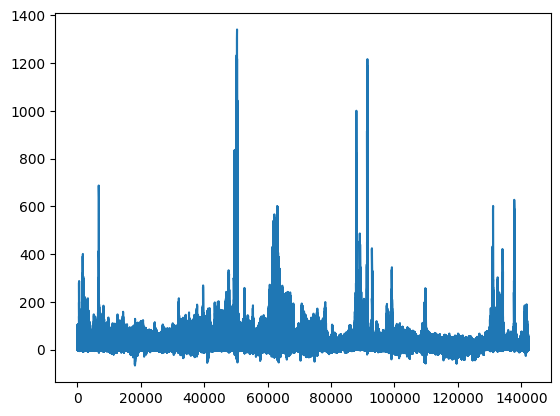

In [27]:
plt.plot(df_parquet["MW"])
print(df_parquet.columns)

In [29]:
print(df_parquet.INTERVALSTARTTIME_GMT[np.argmax(df_parquet.MW)])
print(df_parquet.MW[np.argmax(df_parquet.MW)])

2022-09-08T06:00:00-00:00
-5.18381


In [30]:
# Convert INTERVALSTARTTIME_GMT to datetime if it's not already
df_parquet["INTERVALSTARTTIME_GMT"] = pd.to_datetime(
    df_parquet["INTERVALSTARTTIME_GMT"]
)

# Resample on an hourly basis and take the first value of each hour
resampled_df = df_parquet.resample("H", on="INTERVALSTARTTIME_GMT").first()

# Keep only the start time and value columns
resampled_df = resampled_df[["MW"]].reset_index()

# Display the first few rows of the resampled DataFrame
resampled_df

C:\Users\Astro\AppData\Local\Temp\ipykernel_12944\3885846716.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_df = df_parquet.resample("H", on="INTERVALSTARTTIME_GMT").first()


,INTERVALSTARTTIME_GMT,MW
0,2021-07-15 07:00:00+00:00,49.82027
1,2021-07-15 08:00:00+00:00,0.00000
2,2021-07-15 09:00:00+00:00,48.06374
3,2021-07-15 10:00:00+00:00,-2.04032
4,2021-07-15 11:00:00+00:00,0.00000
...,...,...
28435,2024-10-12 02:00:00+00:00,-0.24101
28436,2024-10-12 03:00:00+00:00,54.06572
28437,2024-10-12 04:00:00+00:00,-2.20589
28438,2024-10-12 05:00:00+00:00,0.00000


In [31]:
resampled_df.to_csv("./data/LMP/hourly_data.csv")